In [2]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import tree
from sklearn.model_selection import GridSearchCV


In [3]:
#Load the file 

train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

full_df=[train,test]

#Show the data-Train 
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
#Step 1: Explore data and create extra columns that might be helpful for analysis


"""

Other factor that might affect the result: 
 1. Have a cabin or not -> create a column "has_cabin"
 2. Family size  -> create a column "FamilySize"
 3. Is it single travelor? -> create a column "IsAlone"
 4. Occupation -> create a column "Occupation "
 
"""






'\n\nOther factor that might affect the result: \n 1. Have a cabin or not -> create a column "has_cabin"\n 2. Family size  -> create a column "FamilySize"\n 3. Is it single travelor? -> create a column "IsAlone"\n 4. Occupation -> create a column "Occupation "\n \n'

Text(0.5, 1.0, 'Counts for cabins')

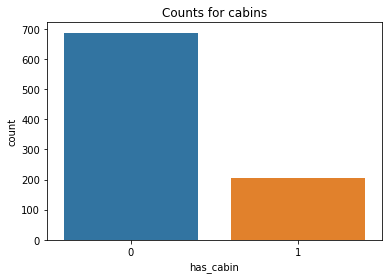

In [6]:


#Step1.1 Create a column-has_cabin to determine if the passanger has cabin or not 

    #1 means having cabin ; 0 means having no cabin

train['has_cabin']=train['Cabin'].apply(lambda x:0 if type(x) == float else 1)
test['has_cabin']=test['Cabin'].apply(lambda x:0 if type(x) == float else 1)

    #Plot
sns.countplot(x='has_cabin', data=train).set_title('Counts for cabins')

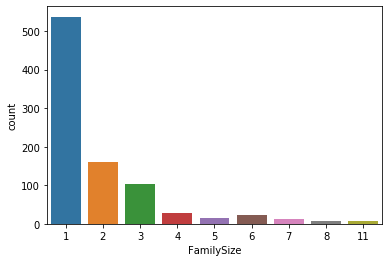

In [7]:
#Step1.2 Create Family size
train['FamilySize']=train['SibSp'] + train['Parch'] + 1
test['FamilySize']=test['SibSp']+ test['Parch'] + 1 

    #plot 

sns.countplot(x="FamilySize", data=train)

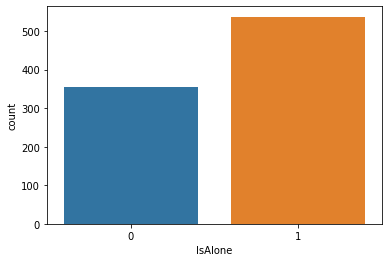

In [8]:
#Step1.3 Create IsAlone

    #Train dataset    

train['IsAlone']=0
train.loc[train['FamilySize'] == 1, 'IsAlone'] = 1

    #Test dataset

test['IsAlone']=0
test.loc[test['FamilySize'] == 1, 'IsAlone'] = 1

    #Plot

sns.countplot(x='IsAlone', data=train)

In [9]:
    #Check the number of IsAlone and FamilySize is consistence

    #Train
print(len(train['FamilySize']==1) == len(train['IsAlone']==1))
    #Test
print(len(test['FamilySize']==1) == len(test['IsAlone'] ==1))

True
True


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

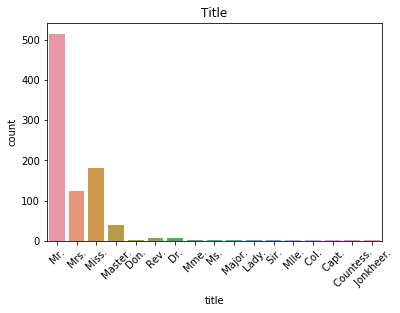

In [10]:
#Step1.4 Create occupation column-title 
    #From Data Camp-https://www.datacamp.com/community/tutorials/feature-engineering-kaggle

    #re.search: a function help you fine those data have similar patter ex.Mr. Miss. 
train['title']=train.Name.apply(lambda x: re.search(' ([A-Z][a-z]+\.)',x).group(0))
test['title']=test.Name.apply(lambda x: re.search(' ([A-Z][a-z]+\.)',x).group(0))

sns.countplot(x='title', data=train).set_title("Title")
plt.xticks(rotation=45)



In [11]:
#Step1.4.2 Mr. Mrs. Miss. Master are the 4 largest groups-> Regroup title into 5 groups

    #Create a list of title

title_list_train=list(set(train['title']))
title_list_test=list(set(test['title']))

    #Test the list of two dataset is the same

print(title_list_test == title_list_train)


False


In [12]:
    #Create a new column of title for both dataset
train['New_title']=train['title']
test['New_title']=test['title']

    #Creare a rare group list 
rare_group_list=[' Mme.',
 ' Col.',
 ' Countess.',
 ' Mlle.',
 ' Rev.',
 ' Capt.',
 ' Lady.',
 ' Jonkheer.',
 ' Don.',
 ' Major.',
 ' Dr.',
 ' Sir.']



In [13]:
    #Create a new group for titles 
    
 #Replace 'Miss' to 'Ms'
train['New_title']=train['New_title'].replace(' Miss.',' Ms.')
test['New_title']=test['New_title'].replace(' Miss.',' Ms.')
    
  #Group rare titles to "Rare "
train['New_title']=train['New_title'].replace(rare_group_list,"Rare")
test['New_title']=test['New_title'].replace(rare_group_list,"Rare")

In [14]:
#Step2. Detect & fillout missing values


In [15]:
#Step2.1  Show the numbers of missing values for each column

print(train.isnull().sum())
print(test.isnull().sum())

#Step2.2  Determine the strategy of filling the missing values

#Strategy: 
    
"""
Age- fill the mean  +- standar deviation and randomly fill the values in the model
Cabin- use the fare range to decide it has cabin or not
Drop- Embarked (It has only few missing values)
    
"""
    
    
#Step2.3 Fill out missing 

    #Filling out missing values-Age
    
dataset=[train,test]
for data in dataset:
    
    age_avg=data['Age'].mean()
    age_std=data['Age'].std()
    age_null_count=data['Age'].isnull().sum()
    age_null_random_list= np.random.randint(age_avg - age_std , age_avg+age_std , size=age_null_count)
    #Use mean +- std to randomly fill out values
    data.loc[np.isnan(data['Age']),'Age']= age_null_random_list
    
    test['Fare']=test.Fare.fillna(test.Fare.mean())

#Step2.4 Drop missing values 


train=train.dropna(subset=['Embarked'])

    #drop the reluctant column-Cabin
    
train=train.drop("Cabin", axis=1)
test=test.drop("Cabin", axis=1)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
has_cabin        0
FamilySize       0
IsAlone          0
title            0
New_title        0
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
has_cabin        0
FamilySize       0
IsAlone          0
title            0
New_title        0
dtype: int64


In [16]:
#Check the missing values- make sure that the dataset is clean
print(train.isnull().sum())
print(test.isnull().sum())


train.Embarked.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
has_cabin      0
FamilySize     0
IsAlone        0
title          0
New_title      0
dtype: int64
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
has_cabin      0
FamilySize     0
IsAlone        0
title          0
New_title      0
dtype: int64


0

In [17]:
#Mapping your data 

    
 #mapping sex
train['Sex']=train['Sex'].map({'female':0, 'male':1}).astype(int)
test['Sex']=test['Sex'].map({'female':0, 'male':1}).astype(int)
 #mapping title
train['New_title']=train['New_title'].map({' Mr.':1,' Mrs.':2,' Ms.':3,'Rare':4,' Master.':5})
train['New_title']=train['New_title'].fillna(0)

test['New_title']=test['New_title'].map({' Mr.':1,' Mrs.':2,' Ms.':3,'Rare':4,' Master.':5})
test['New_title']=test['New_title'].fillna(0)

#mapping Embarked
train['Embarked']=train['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
test['Embarked']=test['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)

    

In [18]:
#mapping fare
train.loc[train['Fare'] <= 7.91, 'Fare']=0
train.loc[(train['Fare'] > 7.91) & (train['Fare'] <=14.454), 'Fare'] = 1
train.loc[(train['Fare'] > 14.454) & (train['Fare'] <=31), 'Fare'] = 2
train.loc[(train['Fare'] > 31), 'Fare']=3
train['Fare'] = train['Fare'].astype(int)
    
test.loc[test['Fare'] <= 7.91, 'Fare']=0
test.loc[(test['Fare'] > 7.91) & (test['Fare'] <=14.454), 'Fare'] = 1
test.loc[(test['Fare'] > 14.454) & (test['Fare'] <=31), 'Fare'] = 2
test.loc[(test['Fare'] > 31), 'Fare']=3
test['Fare'] = test['Fare'].astype(int)
#mapping age
train.loc[train['Age'] <= 16, 'Age'] =0
train.loc[(train['Age'] > 16) & (train['Age'] <= 32), 'Age' ] = 1
train.loc[(train['Age'] > 32) & (train['Age'] <= 48), 'Age' ] = 2
train.loc[(train['Age'] > 48),'Age']=3
train['Age'] = train['Age'].astype(int)

test.loc[test['Age'] <= 16, 'Age'] =0
test.loc[(test['Age'] > 16) & (test['Age'] <= 32), 'Age' ] = 1
test.loc[(test['Age'] > 32) & (test['Age'] <= 48), 'Age' ] = 2
test.loc[(test['Age'] > 48),'Age']=3
test['Age']=test['Age'].astype(int)



In [19]:
#Drop non-numeric column in a new dataset

drop_list= ['PassengerId','Name','Ticket','SibSp','title']

train_new=train.drop(drop_list, axis=1)
test_new=test.drop(drop_list, axis=1)

#Show the columns 
train_new.columns
test_new.columns



Index(['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'has_cabin',
       'FamilySize', 'IsAlone', 'New_title'],
      dtype='object')

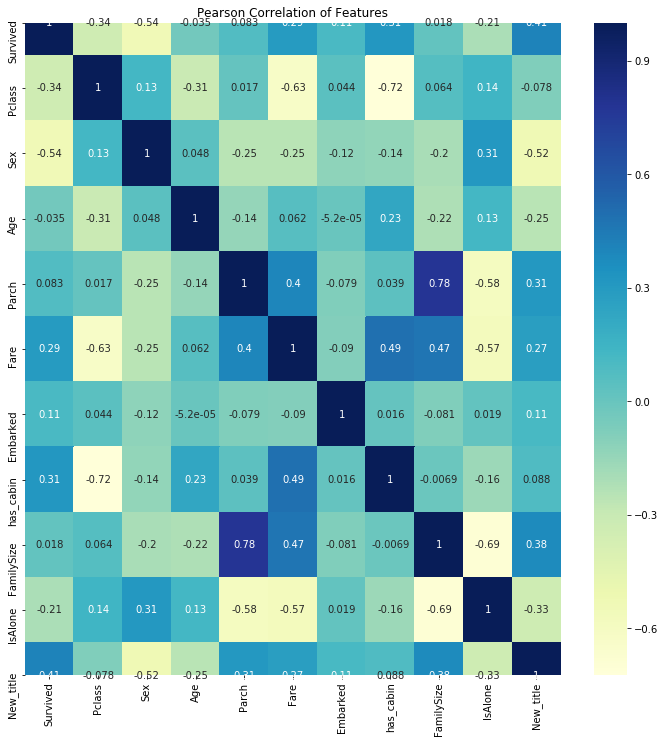

In [20]:
#Correlation Matrix
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features')
sns.heatmap(train_new.astype(float).corr(), annot = True,cmap="YlGnBu")




In [21]:
#Feature Engineering 

"""
Title & Sex are top 2 variables correated to Survived 

"""

#Create a copy dataset to prevent from original dataset being modeified
title_sex=train.copy()[['New_title','Sex']]


#Create a title feature in title_sex df

title_sex[['New_title','Sex']].groupby(['New_title']).agg(['mean','count','sum'])

Sex           
               mean count  sum
New_title                     
1          1.000000   517  517
2          0.000000   124    0
3          0.000000   182    0
4          0.769231    26   20
5          1.000000    40   40

In [22]:
#Building models - Transform data into array for scikit-learn

X=train_new.drop('Survived', axis=1).values

y=train_new['Survived'].values

    

#Set up the hyperparameter for cross validation

dep = np.arange(1,9)
param_grid = {'max_depth' : dep}

#Instantiate decision tree classifier

clf = tree.DecisionTreeClassifier()

#Instantiate GridSearchCV 

clf_cv = GridSearchCV(clf, param_grid=param_grid, cv=5)

#Fit the data

clf_cv.fit(X,y)


#Print the results

print("Tuned Decision Tree Parameters: {}".format(clf_cv.best_params_))
print("Best score is {}".format(clf_cv.best_score_))

Tuned Decision Tree Parameters: {'max_depth': 3}
Best score is 0.8188976377952756


In [23]:

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Y_pred =clf_cv.predict(test_new)





In [24]:
test["Survived"] = Y_pred

In [25]:
test[['PassengerId','Survived']].to_csv('/Users/junetzeng/Desktop/DD-Module A/Kaggle/First attemp/result.csv', index=False)